First, we use basic data science operations using pandas and numpy to explore the data. We import necessary libraries first.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:

!pip install -U -q PyDrive

Since our dataset is in google drive, we need to connect collab to google drive to access the data. Uploading dataset to collab was slow. Also, such folders are deleted when new session is resumed.

In [ ]:

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:

downloaded = drive.CreateFile({'id':"1_IY06fo4FPwirTSbGWiGvAqoDeQjbqa0"}) 
downloaded.GetContentFile('training.csv') 

So, we have extracted the training data files. Now using panda, we read the csv file and assign column names since there is no header in the dataset. 

In [ ]:
cols = ['sentiment','id','date','query_string','user','text']

df = pd.read_csv("/content/training.csv",engine='python', header=None, names=cols) 

In [ ]:
df.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
df.sentiment.value_counts()


4    800000
0    800000
Name: sentiment, dtype: int64

We will be analysing the text of tweets so we drop the unrequired columns from the dataframe.

In [ ]:
df.drop(['id','date','query_string','user'],axis=1,inplace=True)

#Data preparation

First thing we need to do is to prepare the data. We observe the length and type of the text data and conclude following transformation operations to prepare them before analysis.
1. Removing HTML decoding in the text
2. Mentions removal
3. URL links removal
4. UTF marks removal
5. Hashtag removal

In [ ]:

df['pre_clean_len']=[len(t) for t in df.text]

In [ ]:
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':df.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':df.text.dtype,
        'description':'tweet text'
    },
    'pre_clean_len':{
        'type':df.pre_clean_len.dtype,
        'description':'Length of the tweet before cleaning'
    },
    'dataset_shape':df.shape
}
pprint(data_dict)

{'dataset_shape': (1600000, 3),
 'pre_clean_len': {'description': 'Length of the tweet before cleaning',
                   'type': dtype('int64')},
 'sentiment': {'description': 'sentiment class - 0:negative, 1:positive',
               'type': dtype('int64')},
 'text': {'description': 'tweet text', 'type': dtype('O')}}


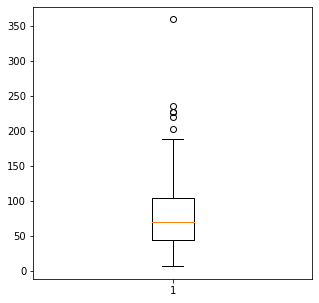

In [ ]:
#check the overall length of the strings with box plot
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(df.pre_clean_len)
plt.show()

In [ ]:

#check the tweets that are more than 140 char long
df[df.pre_clean_len > 140].head(10)


,sentiment,text,pre_clean_len
213,0,Awwh babs... you look so sad underneith that s...,142
279,0,Whinging. My client&amp;boss don't understand ...,145
343,0,@TheLeagueSF Not Fun &amp; Furious? The new ma...,145
400,0,#3 woke up and was having an accident - &quot;...,144
464,0,"My bathtub drain is fired: it haz 1 job 2 do, ...",146
492,0,"pears &amp; Brie, bottle of Cabernet, and &quo...",150
747,0,Have an invite for &quot;Healthy Dining&quot; ...,141
957,0,Damnit I was really digging this season of Rea...,141
1064,0,Why do I keep looking...I know that what I rea...,141
1071,0,Used the term &quot;Fail Whale&quot; to a clie...,148


In [ ]:
!pip install beautifulsoup4

In [ ]:


from bs4 import BeautifulSoup 
import re
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[^ ]+'
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

combined_pat = r'|'.join((pat1, pat2))
def tweet_cleaner(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    clean = re.sub(www_pat, '', clean)
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    lower_case = letters_only.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()
    
testing = df.text[:10]
test_result = []
for t in testing:
    test_result.append(tweet_cleaner(t))
test_result


['awww that bummer you shoulda got david carr of third day to do it',
 'is upset that he can update his facebook by texting it and might cry as result school today also blah',
 'dived many times for the ball managed to save the rest go out of bounds',
 'my whole body feels itchy and like its on fire',
 'no it not behaving at all mad why am here because can see you all over there',
 'not the whole crew',
 'need hug',
 'hey long time no see yes rains bit only bit lol fine thanks how you',
 'nope they didn have it',
 'que me muera']

In [ ]:
nums=[0,1600000]
print ("Cleaning and parsing the tweets\n")
clean_tweet_texts=[]
for i in range(nums[0],nums[1]):
  if((i+1)%10000 == 0):
    print ("Tweets %d of %d has been processed" %(i+1, nums[1]))
  clean_tweet_texts.append(tweet_cleaner(df['text'][i]))


Cleaning and parsing the tweets

Tweets 10000 of 1600000 has been processed
Tweets 20000 of 1600000 has been processed
Tweets 30000 of 1600000 has been processed
Tweets 40000 of 1600000 has been processed
Tweets 50000 of 1600000 has been processed
Tweets 60000 of 1600000 has been processed
Tweets 70000 of 1600000 has been processed
Tweets 80000 of 1600000 has been processed
Tweets 90000 of 1600000 has been processed
Tweets 100000 of 1600000 has been processed
Tweets 110000 of 1600000 has been processed
Tweets 120000 of 1600000 has been processed
Tweets 130000 of 1600000 has been processed
Tweets 140000 of 1600000 has been processed
Tweets 150000 of 1600000 has been processed
Tweets 160000 of 1600000 has been processed
Tweets 170000 of 1600000 has been processed
Tweets 180000 of 1600000 has been processed
Tweets 190000 of 1600000 has been processed
Tweets 200000 of 1600000 has been processed
Tweets 210000 of 1600000 has been processed
Tweets 220000 of 1600000 has been processed
Tweets 2

**Now, we save the cleaned data as CSV file which we will be using for the spark analysis.**

In [ ]:
clean_df=pd.DataFrame(clean_tweet_texts, columns=['text'])
clean_df['target'] = df.sentiment
clean_df.head()


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can update his facebook by te...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [ ]:
clean_df.count()

text      1600000
target    1600000
dtype: int64

In [ ]:
clean_df.to_csv('clean_tweet.csv',encoding='utf-8')
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

/usr/local/lib/python3.6/dist-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can update his facebook by te...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


#Now, we need to install findspark and pyspark on collab since they are not available by default.#

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null


In [ ]:
!wget -q https://downloads.apache.org/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop2.7.tgz


In [ ]:
!tar -xvf spark-3.0.0-preview2-bin-hadoop2.7.tgz


spark-3.0.0-preview2-bin-hadoop2.7/
spark-3.0.0-preview2-bin-hadoop2.7/data/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/
spark-3.0.0-preview2-bin-hadoop2.7/data/streaming/AFINN-111.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_binary_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_kmeans_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_multiclass_classification_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_lda_libsvm_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/iris_libsvm.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pagerank_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/sample_linear_regression_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/pic_data.txt
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/test.data
spark-3.0.0-preview2-bin-hadoop2.7/data/mllib/als/sample_movielens_rati

In [ ]:
!pip install -q findspark


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop2.7"


In [ ]:
import findspark
findspark.init()
import pyspark as ps
import warnings
from pyspark.sql import SQLContext

In [ ]:
#we first create a SparkContext that operates in a cluster

try: 
  #create sparkcontext on CPUs available
  sc=ps.SparkContext.getOrCreate()
  sqlContext=SQLContext(sc)
  print("Just created a sparkcontet")
except ValueError: 
  warnings.warn("SparkContext already exists")

Just created a sparkcontet


Spark has three different data structures available through its APIs: RDD, Dataframe, Dataset. We can use anyone based on the requirement. RDDs can offer low-level functionality and control but dataframe and dataset offers custom view and structure, offers high level operations, saves space and exectues at superior speeds.

In [ ]:
tweet_df=sqlContext.read.format('com.databricks.spark.csv').options(header='true', inferschema='true').load('/content/clean_tweet.csv')


In [ ]:
type(tweet_df)

pyspark.sql.dataframe.DataFrame

In [ ]:
tweet_df.show(5)
tweet_df.count()

+---+--------------------+------+
|_c0|                text|target|
+---+--------------------+------+
|  0|awww that bummer ...|     0|
|  1|is upset that he ...|     0|
|  2|dived many times ...|     0|
|  3|my whole body fee...|     0|
|  4|no it not behavin...|     0|
+---+--------------------+------+
only showing top 5 rows



1600000

In [ ]:
tweet_df=tweet_df.dropna()
tweet_df.count()

1596516

In [ ]:
#breaking the datasets into training  and test sets
(train_set, test_set)=tweet_df.randomSplit([0.70, 0.30], seed=2000)

In [ ]:
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

In [ ]:
tokenizer = Tokenizer(inputCol="text", outputCol="words")
hashtf = HashingTF(numFeatures=2**16, inputCol="words", outputCol='tf')
idf = IDF(inputCol='tf', outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
label_stringIdx = StringIndexer(inputCol = "target", outputCol = "label")
pipeline = Pipeline(stages=[tokenizer, hashtf, idf, label_stringIdx])

pipelineFit = pipeline.fit(train_set)
train_df = pipelineFit.transform(train_set)
test_df = pipelineFit.transform(test_set)
train_df.show(5)

+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|_c0|                text|target|               words|                  tf|            features|label|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
|  0|awww that bummer ...|     0|[awww, that, bumm...|(65536,[18354,216...|(65536,[18354,216...|  0.0|
|  1|is upset that he ...|     0|[is, upset, that,...|(65536,[1981,3085...|(65536,[1981,3085...|  0.0|
|  2|dived many times ...|     0|[dived, many, tim...|(65536,[2548,2888...|(65536,[2548,2888...|  0.0|
|  3|my whole body fee...|     0|[my, whole, body,...|(65536,[1880,9243...|(65536,[1880,9243...|  0.0|
|  4|no it not behavin...|     0|[no, it, not, beh...|(65536,[1968,8538...|(65536,[1968,8538...|  0.0|
+---+--------------------+------+--------------------+--------------------+--------------------+-----+
only showing top 5 rows



In [ ]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)
lrModel = lr.fit(train_df)
predictions = lrModel.transform(test_df)
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8546541739482671

In [ ]:
type(predictions)

pyspark.sql.dataframe.DataFrame

In [ ]:
#can be written to a cluster like this
#predictions.write.csv("hdfs://cluster/usr/hdfs/prediction/result.csv")

BinaryClassificationEvaluator evaluates is by default areaUnderROC. Hence this is not the  measure of accuracy. So, we compute accuracy by counting the number of predictions matching the label and dividing it by the total entries.

In [ ]:
accuracy = predictions.filter(predictions.label == predictions.prediction).count() / float(test_set.count())
accuracy

0.7853091901546577

Converting pyspark dataframe to pandas dataframe for visualization



In [ ]:
pandas_df = predictions.select("*").toPandas()


In [ ]:
#plotting confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
cnf_matrix=confusion_matrix(pandas_df["label"], pandas_df["prediction"], labels=[1,0])
print (cnf_matrix)

[[191035  48722]
 [ 54169 185326]]


Confusion matrix, without normalization
[[191035  48722]
 [ 54169 185326]]


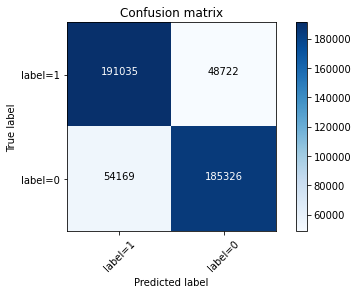

In [ ]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['label=1','label=0'],normalize= False,  title='Confusion matrix')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd732954ac8>]],
      dtype=object)

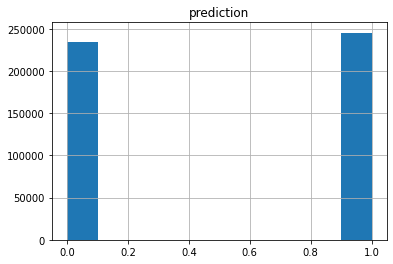

In [ ]:
pandas_df.hist(column="prediction")

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4496947630>]],
      dtype=object)

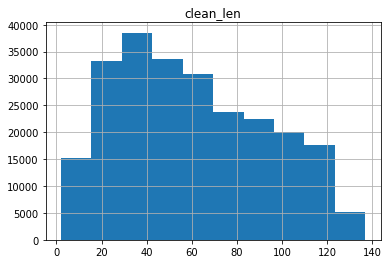

In [ ]:

pandas_df['clean_len']=[len(t) for t in pandas_df.text]
pandas_df.hist(column="clean_len")